In [1]:
import requests
import pandas as pd
import hmac
import hashlib
from datetime import datetime
import numpy as np

In [2]:
import credentials
secret_bytes = bytes(credentials.secret , 'latin-1')

In [3]:
# rates = requests.get("https://api.coinbase.com/v2/exchange-rates").json()["data"]["rates"]


In [4]:
def generate_access_sign(timestamp, method, requestPath, body):
    message = timestamp + method + requestPath + body
    message_bytes = bytes(message , 'latin-1')
    signature = hmac.new(secret_bytes, message_bytes, digestmod = hashlib.sha256).hexdigest()
    return signature

In [5]:
BASE = "https://api.coinbase.com"
PATH = "/v2/accounts?limit=300"
timestamp = str(round(datetime.now().timestamp()))
signature = generate_access_sign(timestamp, "GET", PATH, "")
HEADERS = {
    "CB-ACCESS-KEY": credentials.key,
    "CB-ACCESS-SIGN": signature,
    "CB-ACCESS-TIMESTAMP": timestamp
}
wallets_request = requests.get(BASE+PATH, headers=HEADERS)

In [6]:
assets = pd.DataFrame.from_dict(wallets_request.json()["data"])
assets["balance"] = assets["native_balance"].apply(lambda balance: float(balance["amount"]))
assets = assets[["currency", "balance"]].set_index("currency")
assets.rename_axis("symbol", inplace=True)

In [7]:
mc_dicts = []
for page in range(1, 20):
    results = requests.get(f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page=250&page={page}&sparkline=false").json()
    mc_dicts.extend(results)

In [8]:
mc = pd.DataFrame.from_dict(mc_dicts)
mc["symbol"] = mc["symbol"].str.upper()
mc.set_index("symbol", inplace=True)
mc = mc[["market_cap"]]
mc = mc[~(mc["market_cap"] == 0)]
# mc[mc.index.duplicated()].sort_index()


In [9]:
df = assets.join(mc)

In [10]:
weights = pd.read_csv('active_weights.csv', index_col="symbol")
weights["weight"] = pd.to_numeric(weights["weight"])
df = df.join(weights)

In [11]:
# Missing market caps
df[df["market_cap"].isnull()]

,balance,market_cap,weight
symbol,,,
CGLD,0.00,NaN,0.9
LOOM,0.00,NaN,NaN
PAX,0.00,NaN,NaN
USD,0.08,NaN,NaN


In [12]:
df = df[~df["market_cap"].isnull()]

In [13]:
# To be weighted
df[df["weight"].isnull()].sort_values("market_cap", ascending=False)[["market_cap", "weight"]]

,market_cap,weight
symbol,,


<AxesSubplot:ylabel='Frequency'>

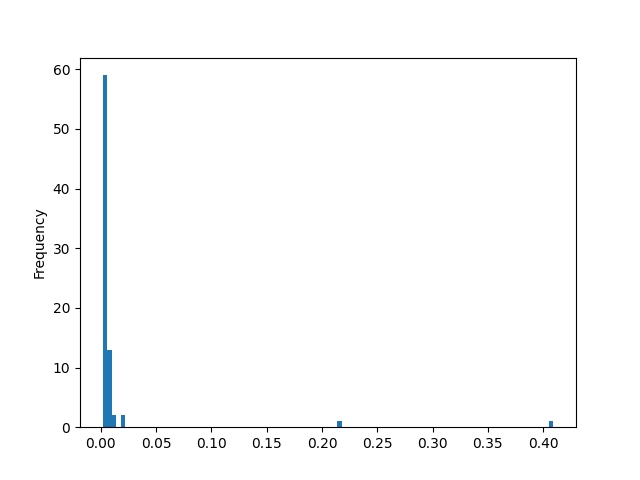

In [14]:
df = df[~df["weight"].isnull()]
df = df[~(df["weight"] == 0)]
df["custom_weighted_mc"] = df["market_cap"] * df["weight"]
df["custom_allocation_target"] = df["custom_weighted_mc"] / df["custom_weighted_mc"].sum()
df["log_custom_weighted_mc"] = np.log(df["custom_weighted_mc"])
df["log_custom_weighted_allocation_target"] = df["log_custom_weighted_mc"] / df["log_custom_weighted_mc"].sum()
log_weight = 0.3
df["fully_weighted_allocation_target"] = (df["log_custom_weighted_allocation_target"] * log_weight) + (df["custom_allocation_target"] * (1-log_weight))
%matplotlib widget
df["fully_weighted_allocation_target"].plot.hist(bins=100)

In [18]:
df["current_allocation"] = df["balance"] / df["balance"].sum()
df["target_allocation"] = df["fully_weighted_allocation_target"] * credentials.target_portfolio_size
df["delta"] = df["target_allocation"] - df["balance"]
# df[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)
# df.sort_values("delta", ascending=False)

# TODO portfolio size neutral trades

AttributeError: module 'credentials' has no attribute 'target_portfolio_size'

In [17]:
# TODO exclude TLH
